In [1]:
import numpy as np
import sys
import time
from tqdm import tqdm
import matplotlib
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits
from ipywidgets import interact
from sklearn.decomposition import PCA

In [77]:
def sigmoid(X):
    return 1. / (1. + np.exp(-X))

def sigmoid_grad(X):
    return sigmoid(X) * ( 1 - sigmoid(X) )

def relu(X):
    return (X + np.abs(X)) / 2.

def relu_grad(X):
#     return relu(X) - relu(X-1)
    return sigmoid(X)

def selu(X):
    l = 1.0507
    a = 1.6733
    r = relu(X)
    rm = -relu(-X)
    return l*(r + a*(np.exp(rm)-1))

def selu_grad(X):
    return sigmoid(X)

class NeuralNetwork(object):
    def __init__(self, layers=(2,2,1), learning_rate=0.1, num_epochs=10, batch_size=None, activation='selu', use_pca=None, invert_gradient=False, epoch_inverse_threshold=1):
        self.num_layers = len(layers)
        self.layers = layers
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.use_pca = use_pca if use_pca is not None else (False,)*len(layers)
        self._batch_size_arg = batch_size
        self.invert_gradient = invert_gradient
        self.epoch_inverse_threshold = round(epoch_inverse_threshold * self.num_epochs)
        
        self.nodes = list(range(self.num_layers))
        self.grad = list(range(self.num_layers))
        self.dw = list(range(self.num_layers-1))
        self.weights = list(range(self.num_layers-1))
        self.weights_history = list(range(self.num_layers-1))
        # self.nodes[0] = np.zeros(self.num_layers[0])
        for i in range(self.num_layers - 1):
            # self.nodes[i+1] = np.zeros(self.num_layers[i+1])
            self.weights[i] = np.random.randn(self.layers[i], self.layers[i+1])
            self.weights_history[i] = np.zeros((self.num_epochs+1, self.layers[i], self.layers[i+1]))
            self.weights_history[i][0] = self.weights[i]

        self.activation, self.activation_grad = self._activation_function(activation)
        self.training_accuracy = np.zeros((self.num_epochs))
        self.mse = np.zeros((self.num_epochs))
    
    def _initialise_pca(self, X):
        Xt = X.copy()
        for i in range(self.num_layers - 1):
            Xt = self._transform(Xt, layer=i)
            if self.use_pca[i]:                
                pca = PCA(n_components=self.layers[i+1])
                pca.fit(Xt)
                for j in range(self.layers[i+1]):
                    self.weights[i].T[j] = pca.components_[j]
    
    def _activation_function(self, name):
        funcs = {
            'relu': (relu, relu_grad),
            'sigmoid': (sigmoid, sigmoid_grad),
            'selu': (selu, selu_grad),
        }
        return funcs[name]

    def _transform(self, X, layer=1):
        if layer == 0:
            return X
        return self.activation(np.dot(X, self.weights[layer-1]))
    
    def _transform_history(self, X, layer=1, epoch=None):
        epoch = self.num_epochs - 1 if epoch is None else epoch
        if layer == 0:
            return X
        return self.activation(np.dot(X, self.weights_history[layer-1][epoch]))
    
    def _cum_transform(self, X, layer=1):
        if layer > self.num_layers:
            raise Exception("There are only %d layers, but you specified the %dth layer" % (self.num_layers, layer))
        out = X
        for i in range(1, layer):
            out = self._transform(out, layer=i)
        return out
    
    def _compute_gradient(self, x, y):
        pass
    
    def _invert_gradient(self, epoch=0):
        if self.invert_gradient and epoch < self.epoch_inverse_threshold:
            return -1
        return 1
    
    def _forward(self, X):
        self.nodes[0] = X
        for i in range(1, self.num_layers):
            self.nodes[i] = self._transform(self.nodes[i-1], layer=i)
        self.output = self.nodes[self.num_layers-1]
        return self.output

    def _backward(self, X, y, epoch=None, save_stats=True):
        n = X.shape[0]
        self._forward(X)
        error = y - self.output
        self.grad[self.num_layers-1] = error * self.activation_grad(self.output)
        for j in range(self.num_layers-2, -1, -1):
            self.grad[j] = np.dot(self.grad[j+1], self.weights[j].T) * self.activation_grad(self.nodes[j])
            self.dw[j] = np.dot(self.nodes[j].T, self.grad[j+1])
            self.weights[j] += self.learning_rate * self.dw[j] / n
            if epoch is not None:
                self.weights_history[j][epoch] = self.weights[j]

        correct = len([e for e in error if abs(e) < 0.5])
        training_accuracy = float(correct) / n
        mse = np.sum(np.square(error)) / n
        if save_stats and epoch is not None:
            self.training_accuracy[epoch] = training_accuracy
            self.mse[epoch] = mse
        return training_accuracy, mse
            
    
    def fit(self, X, y, transfer=False, shuffle=True):
        self.batch_size = round(self._batch_size_arg * X.shape[0]) if self._batch_size_arg is not None and self._batch_size_arg < 1 else self._batch_size_arg
        self.num_batches = X.shape[0]//self.batch_size + 1 if self.batch_size is not None else None
        
        if not transfer and self.use_pca:
            self._initialise_pca(X)
        
        order = np.arange(X.shape[0])
        if shuffle:
            np.random.shuffle(order)
        
        epochs = tqdm(range(self.num_epochs))
        
        for i in epochs:
            if self.batch_size is not None:
                batch_acc = np.zeros(self.num_batches)
                batch_mse = np.zeros(self.num_batches)
                for j in range(self.num_batches):
                    batch_idx = order[self.batch_size*j:self.batch_size*(j+1)]
                    B = X[batch_idx]
                    yb = y[batch_idx]
                    batch_acc[j], batch_mse[j] = self._backward(B, yb, epoch=i, save_stats=False)
                self.training_accuracy[i] = np.mean(batch_acc)
                self.mse[i] = np.mean(batch_mse)
                epochs.set_postfix(loss=self.mse[i], accuracy=self.training_accuracy[i])
            else:
                training_accuracy, mse = self._backward(X, y, epoch=i)
                epochs.set_postfix(loss=mse, accuracy=training_accuracy)
    
    def predict(self, X):
        return self.predict_proba(X)
    
    def predict_proba(self, X):
        return self._forward(X)
    
    def score(self, X, y):
        n = X.shape[0]
        self._forward(X)
        error = y - self.output
        correct = len([e for e in error if abs(e) < 0.5])
        training_accuracy = float(correct) / n
        return training_accuracy
    
    def _mse(self, X, y, epoch=None):
        n = X.shape[0]
        output = self._forward_history(X, epoch=epoch)
        mse = (y - output)**2
        return np.sum(error) / n
    
    def _forward_history(self, X, epoch=None):
        nodes = X
        for i in range(1, self.num_layers):
            nodes = self._transform_history(nodes, layer=i, epoch=epoch)
        output = nodes
        return output

In [14]:
np.random.seed(42)
n = 1000
d = 8
X = np.random.randn(n, d)
m = np.median(np.linalg.norm(X, axis=1))
y = np.array([1 if np.linalg.norm(x) >= m else 0 for x in X])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=42)

/Users/uniyomi/omi/miniconda3/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [100]:
np.random.seed(42)
d = 8
num_epochs = 5000
batch_size = None
learning_rate = 0.1
# learning_rate = 1
layers = (d, 4, 4, 4, 4, 4, 2, 1)

In [101]:
np.random.seed(42)
nn = NeuralNetwork(layers=layers, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, activation='relu')
nn.fit(X_train, y_train[:, None])

100%|██████████| 5000/5000 [00:16<00:00, 294.19it/s, accuracy=0, loss=nan]      


In [102]:
np.random.seed(123)
nn_selu = NeuralNetwork(layers=layers, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, activation='selu')
nn_selu.fit(X_train, y_train[:, None])

100%|██████████| 5000/5000 [00:18<00:00, 277.38it/s, accuracy=0, loss=nan]    


In [103]:
print('NN test accuracy', 100*nn.score(X_test, y_test[:, None]))
print('NN with SELU test accuracy', 100*nn_selu.score(X_test, y_test[:, None]))

NN test accuracy 0.0
NN with SELU test accuracy 0.0


<IPython.core.display.Javascript object>


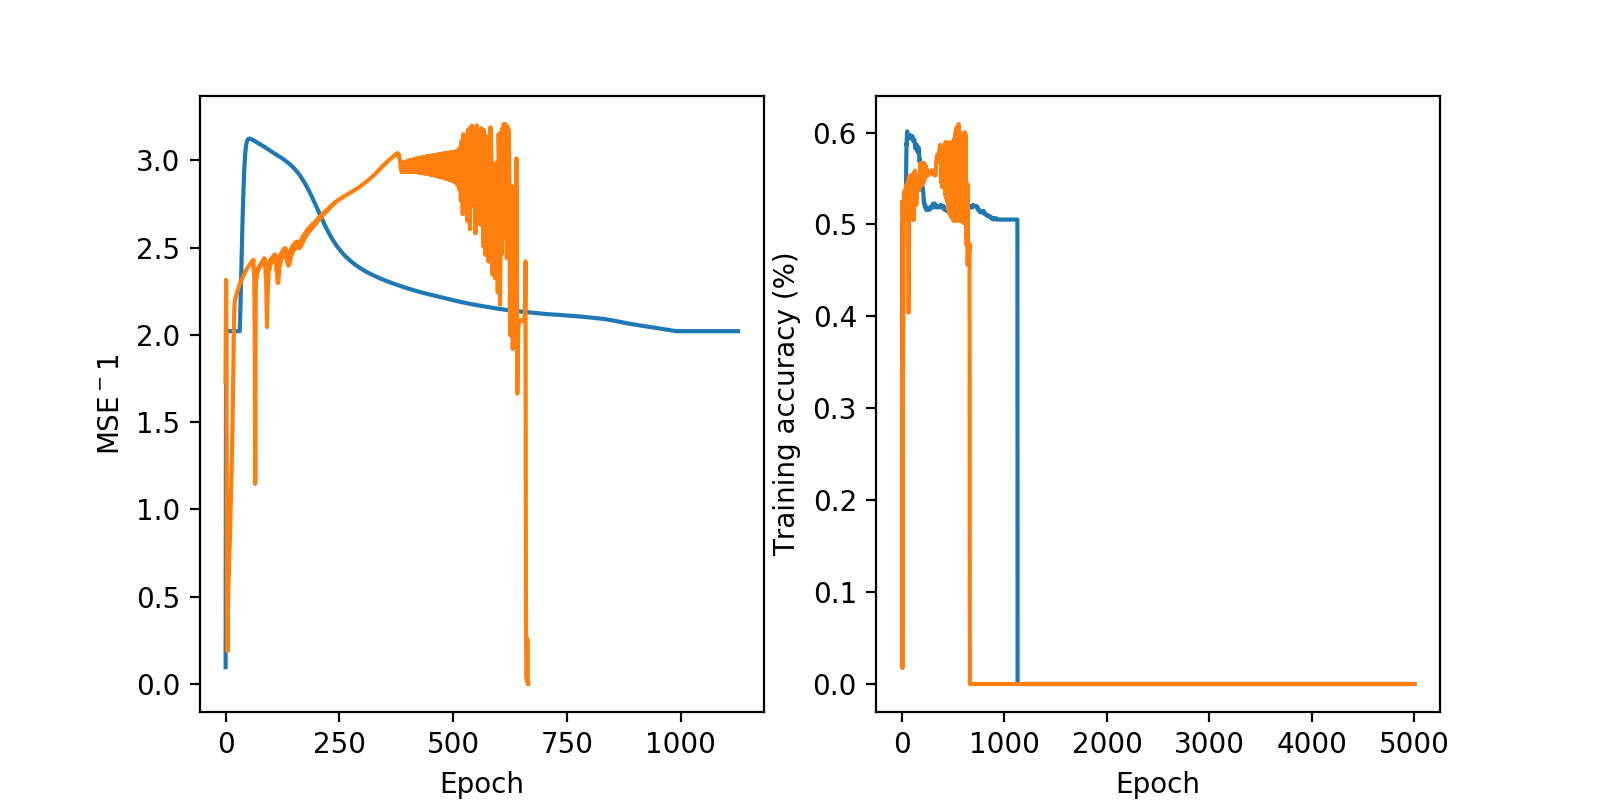

Text(0,0.5,'Training accuracy (%)')

In [104]:
def moving_average(x, window_size=5):
    return np.convolve(x, np.ones((window_size,))/window_size, mode='valid')

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ws = round(nn.mse.shape[0]/3)
# ax.plot(moving_average(nn.mse**-1, window_size=ws))
# ax2.plot(moving_average(nn.training_accuracy, window_size=ws))
ax.plot(nn.mse**-1)
ax.plot(nn_selu.mse**-1)
ax2.plot(nn.training_accuracy)
ax2.plot(nn_selu.training_accuracy)
ax.set_xlabel("Epoch")
ax2.set_xlabel("Epoch")
ax.set_ylabel("MSE$^-1$")
ax2.set_ylabel("Training accuracy (%)")